### Setup

In [1]:
import networkx as nx
import numpy as np
import tweepy, gensim, nltk, yaml, os, sys
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('vader_lexicon')

sys.path.append(os.path.abspath("../src/"))
from helper.utils import *

cred = yaml.load(open('../res/credentials.yml'))
auth = tweepy.OAuthHandler(cred['twitter']['CONSUMER_KEY'], cred['twitter']['CONSUMER_SECRET'])
auth.set_access_token(cred['twitter']['ACCESS_TOKEN'], cred['twitter']['ACCESS_TOKEN_SECRET'])

api = tweepy.API(auth)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/piemontec/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Get Tweets and Conversations

In [3]:
%%time
# stackoverflow
search_options = {
    'q': 'putin',               # query
    'lang': 'en',               # language
    'tweet_mode': 'extended'    # get full tweet text
}
statuses = tweepy.Cursor(api.search, **search_options).items(1000)
tweets   = [[convert(status)] for status in statuses if is_response(status)]
convs    = [extend(tweet) for tweet in tweets]

print('Response tweets:', len(tweets))
print('Max conversation length:', max([len(i) for i in convs]), '\n')

Response tweets: 97
Max conversation length: 18 

CPU times: user 5.03 s, sys: 443 ms, total: 5.48 s
Wall time: 2min 2s


### Build the Graph

In [4]:
%%time

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

ConvGraph = nx.DiGraph()

model = gensim.models.KeyedVectors.load_word2vec_format('../models/pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)

for conv in convs:
    for i, tweet in enumerate(conv):
        similarity = 0.0
        if tweet.reply_to is not None:
            text_source_avg_vector = avg_sentence_vector(conv[i].text.split(),   model=model)
            text_dest_avg_vector   = avg_sentence_vector(conv[i+1].text.split(), model=model)
            similarity = cosine_similarity(text_source_avg_vector, text_dest_avg_vector)
        
        ConvGraph.add_edge(tweet.my_id, tweet.reply_to, weight=similarity)

CPU times: user 1min 39s, sys: 3.94 s, total: 1min 42s
Wall time: 1min 44s


/Users/piemontec/Workspace/app/debate2arg/src/helper/utils.py:69: RuntimeWarning: invalid value encountered in float_scalars
  cosine_similarity = lambda s1, s2: round(np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2)), 4)


#### Draw the Graph

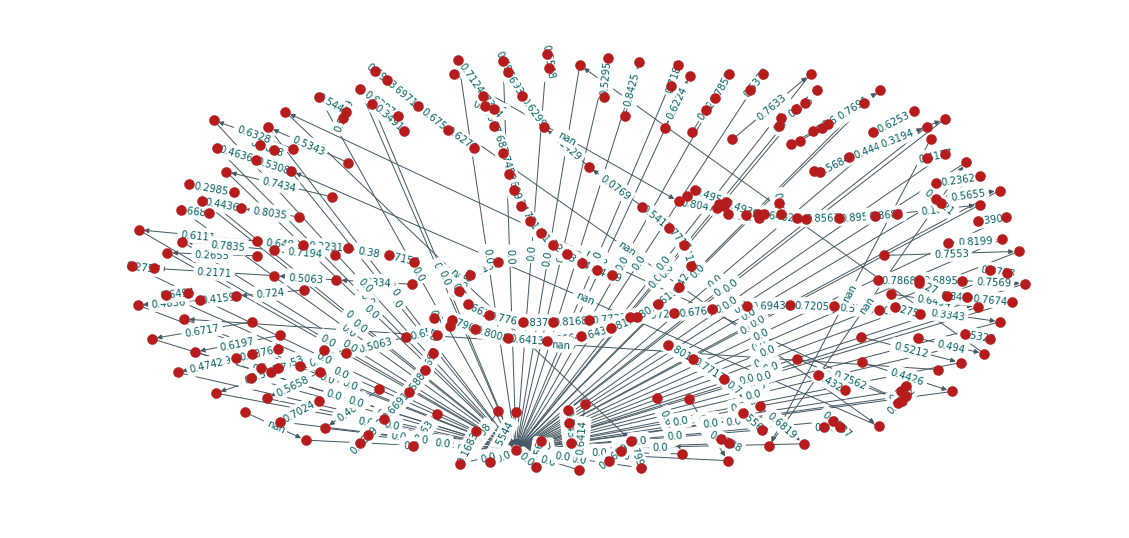

In [5]:
pos = nx.spring_layout(ConvGraph)
edge_labels = nx.get_edge_attributes(ConvGraph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(ConvGraph, pos, **draw_options)
nx.draw_networkx_edge_labels(ConvGraph, pos, edge_labels=edge_labels, font_color='#006064');

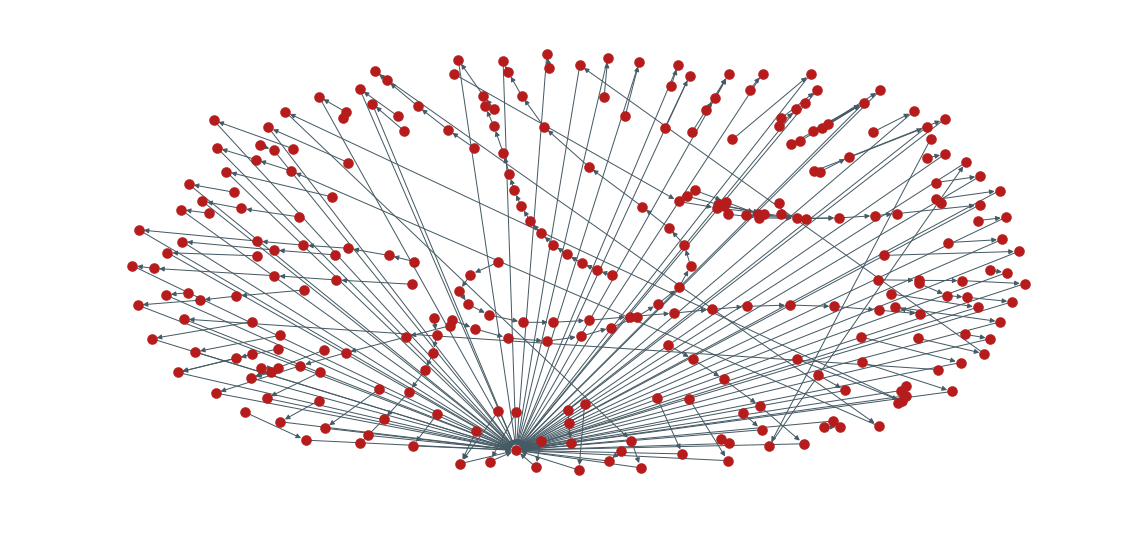

In [6]:
nx.draw(ConvGraph, pos, **draw_options)